# Cifar-10 이미지 분류
### 전체 데이터중 일부만 사용
### Data Augmentation 적용
### 출처: [Achieving 90% accuracy in Object Recognition ](https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/)

#### CIFAR10 데이터 로드

In [1]:
from keras.datasets import cifar10

(X_train, y_train0), (X_test, y_test0) = cifar10.load_data()
print(X_train.shape, X_train.dtype)
print(y_train0.shape, y_train0.dtype)
print(X_test.shape, X_test.dtype)
print(y_test0.shape, y_test0.dtype)

Using TensorFlow backend.


(50000, 32, 32, 3) uint8
(50000, 1) uint8
(10000, 32, 32, 3) uint8
(10000, 1) int32


#### 데이터 확인

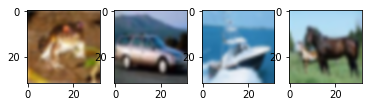

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(141)
plt.imshow(X_train[0], interpolation="bicubic")
plt.grid(False)
plt.subplot(142)
plt.imshow(X_train[4], interpolation="bicubic")
plt.grid(False)
plt.subplot(143)
plt.imshow(X_train[8], interpolation="bicubic")
plt.grid(False)
plt.subplot(144)
plt.imshow(X_train[12], interpolation="bicubic")
plt.grid(False)
plt.show()

#### 자료형 변환 및 스케일링
- X: 실수형으로 정규화
- Y: 1-hot encoding
    * airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

In [3]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

print(X_train.shape, X_train.dtype)

(50000, 32, 32, 3) float32


In [4]:
from keras.utils import np_utils

Y_train = np_utils.to_categorical(y_train0, 10)
Y_test = np_utils.to_categorical(y_test0, 10)
Y_train[:4]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

#### 자료의 일부만 사용하여 모델 테스트 하기

In [5]:
from sklearn.model_selection import train_test_split

seed = 0
X_train, X_test, Y_train, Y_test = train_test_split(X_test, Y_test, 
                                                    test_size=.2, random_state=seed)

#### 모형 구현

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import Activation, BatchNormalization
from keras.regularizers import l2
import numpy as np

np.random.seed(0)

In [8]:
weight_decay = 1e-4
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(weight_decay), 
                 input_shape=X_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [10]:
from keras.optimizers import rmsprop
opt_rms = rmsprop(lr=0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

In [11]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [13]:
#data augmentation
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(X_train)

In [15]:
from keras.callbacks import LearningRateScheduler
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=64),
                    steps_per_epoch=X_train.shape[0] // 64, epochs=125,
                    verbose=1, validation_data=(X_test, Y_test),
                    callbacks=[LearningRateScheduler(lr_schedule)])
'''
history = model.fit(X_train, Y_train, epochs=50, batch_size=64, 
                    validation_data=(X_test, Y_test), verbose=2)
'''

W0820 13:38:30.677202  5880 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/125
125/125 [==============================] - 74s 588ms/step - loss: 2.7439 - acc: 0.2802 - val_loss: 2.4410 - val_acc: 0.3655
Epoch 2/125
125/125 [==============================] - 72s 578ms/step - loss: 2.1183 - acc: 0.3625 - val_loss: 2.5318 - val_acc: 0.3990
Epoch 3/125
125/125 [==============================] - 72s 578ms/step - loss: 1.8571 - acc: 0.4219 - val_loss: 2.1268 - val_acc: 0.4285
Epoch 4/125
125/125 [==============================] - 72s 578ms/step - loss: 1.7021 - acc: 0.4535 - val_loss: 1.7928 - val_acc: 0.4625
Epoch 5/125
125/125 [==============================] - 72s 579ms/step - loss: 1.5668 - acc: 0.4899 - val_loss: 1.4428 - val_acc: 0.5290
Epoch 6/125
125/125 [==============================] - 72s 578ms/step - loss: 1.4739 - acc: 0.5222 - val_loss: 1.4376 - val_acc: 0.5545
Epoch 7/125
125/125 [==============================] - 73s 580ms/step - loss: 1.3842 - acc: 0.5429 - val_loss: 1.6575 - val_acc: 0.5410
Epoch 8/125
125/125 [===========================

Epoch 61/125
125/125 [==============================] - 72s 579ms/step - loss: 0.6118 - acc: 0.8315 - val_loss: 1.0299 - val_acc: 0.7510
Epoch 62/125
125/125 [==============================] - 72s 576ms/step - loss: 0.6104 - acc: 0.8295 - val_loss: 1.0033 - val_acc: 0.7540
Epoch 63/125
125/125 [==============================] - 73s 586ms/step - loss: 0.5988 - acc: 0.8390 - val_loss: 0.9129 - val_acc: 0.7845
Epoch 64/125
125/125 [==============================] - 72s 580ms/step - loss: 0.5964 - acc: 0.8409 - val_loss: 0.9443 - val_acc: 0.7715
Epoch 65/125
125/125 [==============================] - 74s 594ms/step - loss: 0.5922 - acc: 0.8393 - val_loss: 0.9250 - val_acc: 0.7755
Epoch 66/125
125/125 [==============================] - 73s 584ms/step - loss: 0.5846 - acc: 0.8421 - val_loss: 0.9885 - val_acc: 0.7575
Epoch 67/125
125/125 [==============================] - 73s 580ms/step - loss: 0.5767 - acc: 0.8421 - val_loss: 1.1854 - val_acc: 0.7320
Epoch 68/125
125/125 [===================

125/125 [==============================] - 73s 587ms/step - loss: 0.3568 - acc: 0.9206 - val_loss: 0.9829 - val_acc: 0.8035
Epoch 121/125
125/125 [==============================] - 77s 619ms/step - loss: 0.3562 - acc: 0.9220 - val_loss: 0.9442 - val_acc: 0.8020
Epoch 122/125
125/125 [==============================] - 83s 666ms/step - loss: 0.3568 - acc: 0.9216 - val_loss: 0.9477 - val_acc: 0.8075
Epoch 123/125
125/125 [==============================] - 72s 579ms/step - loss: 0.3653 - acc: 0.9193 - val_loss: 0.9467 - val_acc: 0.8050
Epoch 124/125
125/125 [==============================] - 73s 582ms/step - loss: 0.3601 - acc: 0.9224 - val_loss: 0.9469 - val_acc: 0.8050
Epoch 125/125
125/125 [==============================] - 72s 579ms/step - loss: 0.3549 - acc: 0.9230 - val_loss: 0.9260 - val_acc: 0.8045


'\nhistory = model.fit(X_train, Y_train, epochs=50, batch_size=64, \n                    validation_data=(X_test, Y_test), verbose=2)\n'

#### 모델 평가하기

In [16]:
scores = model.evaluate(X_test, Y_test, batch_size=128, verbose=2)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100, scores[0]))


Test result: 80.450 loss: 0.926


#### 모델 저장하기

In [17]:
model.save_weights('model/cifar10-partial-v3.h5') 